In [204]:
import math
import gradio
import os
import numpy as np
import functools
import trimesh
import copy
from scipy.spatial.transform import Rotation
import tempfile
import shutil
import torch
from PIL import Image
from PIL.ImageOps import exif_transpose

import cv2
import os


from mast3r.cloud_opt.sparse_ga import sparse_global_alignment
from mast3r.cloud_opt.tsdf_optimizer import TSDFPostProcess
from mast3r.image_pairs import make_pairs
from mast3r.retrieval.processor import Retriever

import mast3r.utils.path_to_dust3r  # noqa
from dust3r.utils.image import load_images
from dust3r.utils.device import to_numpy
from dust3r.viz import add_scene_cam, CAM_COLORS, OPENGL, pts3d_to_trimesh, cat_meshes
from dust3r.demo import get_args_parser as dust3r_get_args_parser

import matplotlib.pyplot as pl

In [205]:
import os
import torch
import tempfile
from contextlib import nullcontext

from mast3r.demo import get_args_parser, main_demo

from mast3r.model import AsymmetricMASt3R
from mast3r.utils.misc import hash_md5

import mast3r.utils.path_to_dust3r  # noqa
from dust3r.demo import set_print_with_timestamp

import matplotlib.pyplot as pl

In [206]:
class SparseGAState:
    def __init__(self, sparse_ga, should_delete=False, cache_dir=None, outfile_name=None):
        self.sparse_ga = sparse_ga
        self.cache_dir = cache_dir
        self.outfile_name = outfile_name
        self.should_delete = should_delete

    def __del__(self):
        if not self.should_delete:
            return
        if self.cache_dir is not None and os.path.isdir(self.cache_dir):
            shutil.rmtree(self.cache_dir)
        self.cache_dir = None
        if self.outfile_name is not None and os.path.isfile(self.outfile_name):
            os.remove(self.outfile_name)
        self.outfile_name = None

In [207]:
import PIL
import torchvision.transforms as tvf

ImgNorm = tvf.Compose([tvf.ToTensor(), tvf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def _resize_pil_image(img, long_edge_size):
    S = max(img.size)
    if S > long_edge_size:
        interp = PIL.Image.LANCZOS
    elif S <= long_edge_size:
        interp = PIL.Image.BICUBIC
    new_size = tuple(int(round(x*long_edge_size/S)) for x in img.size)
    return img.resize(new_size, interp)

def load_video_as_frames(video_path, load_frequency=1, max_n_frames=np.inf):
    """
    Load an RGB video as a set of frames.

    Args:
        video_path (str): Path to the video file.
        size (tuple): Desired size of the frames (width, height).
        verbose (bool): Whether to print progress.

    Returns:
        list: A list of frames (each frame is a numpy array).
    """
    frames = []
    files = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Cannot open video file: {video_path}")

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        if frame_idx % load_frequency != 0:
            frame_idx += 1
            continue
        frame_idx += 1
        

        # # Resize frame to the desired size
        # frame = cv2.resize(frame, size)

        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        pil_image = Image.fromarray(frame)
        
        img = exif_transpose(pil_image).convert('RGB')
        
        W1, H1 = img.size
        
        img = _resize_pil_image(img, round(224 * max(W1/H1, H1/W1)))
        
        W, H = img.size
        cx, cy = W//2, H//2
        half = min(cx, cy)
        img = img.crop((cx-half, cy-half, cx+half, cy+half))
        
        W2, H2 = img.size

        frames.append(dict(img=ImgNorm(img)[None], true_shape=np.int32(
            [img.size[::-1]]), idx=len(frames), instance=str(len(frames))))
        
        fname = f"{frame_idx:04d}.jpg"
        os.makedirs("input_data", exist_ok=True)
        pil_image.save(os.path.join("input_data",fname))
        files.append(fname)
        
        if len(frames) >= max_n_frames:
            break

    cap.release()
    return frames, files

In [208]:
# Variables

# Scene graph definition
# This is where we define how image pairs are connected

device = "cuda"
# schedule = "cosine"
# lr = 0.01
# niter = 300

model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
# you can put the path to a local checkpoint in model_name if needed
model = AsymmetricMASt3R.from_pretrained(model_name).to(device)


# filelist = [x for x in os.listdir("/scratch/toskov/data/scannetpp_working/0a76e06478/dslr/nerfstudio/") if x.endswith(".jpg")]


In [209]:
# scene_graph_params = [scenegraph_type]
# if scenegraph_type in ["swin", "logwin"]:
#     scene_graph_params.append(str(winsize))
# elif scenegraph_type == "oneref":
#     scene_graph_params.append(str(refid))
# elif scenegraph_type == "retrieval":
#     scene_graph_params.append(str(winsize))  # Na
#     scene_graph_params.append(str(refid))  # k
# if scenegraph_type in ["swin", "logwin"] and not win_cyclic:
#     scene_graph_params.append('noncyclic')
# scene_graph = '-'.join(scene_graph_params)

# scene_graph = "swin-1-noncyclic"
# scene_graph = "swin-10-noncyclic"
scene_graph = "complete"

In [210]:
# imgs = load_images(filelist, size=224, verbose=True)
# if len(imgs) == 1:
#     imgs = [imgs[0], copy.deepcopy(imgs[0])]
#     imgs[1]['idx'] = 1
#     filelist = [filelist[0], filelist[0] + '_2']

imgs, filelist = load_video_as_frames("/scratch/toskov/data/scannetpp_working/0a76e06478/iphone/rgb.mp4", load_frequency=30, max_n_frames=40)

In [211]:
len(imgs)

40

In [212]:
imgs[0]["img"].shape

torch.Size([1, 3, 224, 224])

In [213]:
pairs = make_pairs(imgs, scene_graph=scene_graph, prefilter=None, symmetrize=True, sim_mat=None)

In [214]:
pairs_ids = [f"{p[0]['instance']}, {p[1]['instance']}" for p in pairs]

print(len(pairs), len(pairs_ids))
print(len(set(pairs_ids)))

pairs_ids

1560 1560
1560


['1, 0',
 '2, 0',
 '2, 1',
 '3, 0',
 '3, 1',
 '3, 2',
 '4, 0',
 '4, 1',
 '4, 2',
 '4, 3',
 '5, 0',
 '5, 1',
 '5, 2',
 '5, 3',
 '5, 4',
 '6, 0',
 '6, 1',
 '6, 2',
 '6, 3',
 '6, 4',
 '6, 5',
 '7, 0',
 '7, 1',
 '7, 2',
 '7, 3',
 '7, 4',
 '7, 5',
 '7, 6',
 '8, 0',
 '8, 1',
 '8, 2',
 '8, 3',
 '8, 4',
 '8, 5',
 '8, 6',
 '8, 7',
 '9, 0',
 '9, 1',
 '9, 2',
 '9, 3',
 '9, 4',
 '9, 5',
 '9, 6',
 '9, 7',
 '9, 8',
 '10, 0',
 '10, 1',
 '10, 2',
 '10, 3',
 '10, 4',
 '10, 5',
 '10, 6',
 '10, 7',
 '10, 8',
 '10, 9',
 '11, 0',
 '11, 1',
 '11, 2',
 '11, 3',
 '11, 4',
 '11, 5',
 '11, 6',
 '11, 7',
 '11, 8',
 '11, 9',
 '11, 10',
 '12, 0',
 '12, 1',
 '12, 2',
 '12, 3',
 '12, 4',
 '12, 5',
 '12, 6',
 '12, 7',
 '12, 8',
 '12, 9',
 '12, 10',
 '12, 11',
 '13, 0',
 '13, 1',
 '13, 2',
 '13, 3',
 '13, 4',
 '13, 5',
 '13, 6',
 '13, 7',
 '13, 8',
 '13, 9',
 '13, 10',
 '13, 11',
 '13, 12',
 '14, 0',
 '14, 1',
 '14, 2',
 '14, 3',
 '14, 4',
 '14, 5',
 '14, 6',
 '14, 7',
 '14, 8',
 '14, 9',
 '14, 10',
 '14, 11',
 '14, 1

In [215]:
outdir = "./outputs"
os.makedirs(outdir, exist_ok=True)

scene = sparse_global_alignment(filelist, pairs, outdir, model, device=device)

  0%|          | 0/1560 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:05<00:00,  6.68it/s]


init focals = [230.56728 238.0054  245.2862  238.90901 230.85518 228.84523 231.38362
 225.53604 229.98872 247.021   251.5675  258.24503 267.50302 278.97165
 256.28815 245.64706 227.04799 218.00389 227.9675  230.4568  229.86057
 230.8149  227.4139  214.96942 223.46666 228.5788  219.0625  228.27948
 224.76079 234.84512 238.24489 245.3482  241.69179 239.8228  219.94025
 211.609   218.27048 226.30551 231.71286 236.56302]


100%|██████████| 300/300 [04:31<00:00,  1.10it/s, lr=0.0000, loss=0.072]


>> final loss = 0.07165788859128952


100%|██████████| 300/300 [04:43<00:00,  1.06it/s, lr=0.0000, loss=0.405]

>> final loss = 0.40478765964508057
Final focals = [224.91754 225.49463 225.71979 227.08511 227.08847 226.8559  225.44604
 223.94968 224.97922 228.36963 230.56244 232.46986 229.9602  228.92697
 225.46452 222.97458 222.42387 222.51054 223.07423 219.73027 216.0611
 216.64966 217.77231 220.04219 224.13599 218.51624 217.1954  223.57303
 215.9376  216.38702 218.76772 223.21979 221.466   225.2466  221.08858
 219.13145 218.4026  221.178   231.559   227.61143]


In [216]:
scene.canonical_paths

["./outputs/canon_views/71d5039cf1209140b9105a4696b0b155_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/c3c4a3373f135ab5499021f62052cb8d_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/12b7e07c2610b8aec679d27c3a3ed384_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/0f70e91f5269065285cbf2abd146b44d_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/c30c7f8a184efe94ee1b0ba43940d357_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/ff8ea43b03e06b2591139310b1587805_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/4bd2d60ef12e856921e6ad255da532bb_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/83e51f5cd3fcd56f39dcade8f2c1e019_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/f90c5ec5aa3d43c3ddd26e6773605812_subsample=8_kw={'mode': 'avg-angle'}.pth",
 "./outputs/canon_views/708eddcc863f761031e58481eff1329c_subsample=8_kw={'mode': 'avg-angle'}.pth",


In [217]:
def _convert_scene_output_to_glb(outfile, imgs, pts3d, mask, focals, cams2world, cam_size=0.05,
                                 cam_color=None, as_pointcloud=False,
                                 transparent_cams=False, silent=False):
    assert len(pts3d) == len(mask) <= len(imgs) <= len(cams2world) == len(focals)
    pts3d = to_numpy(pts3d)
    imgs = to_numpy(imgs)
    focals = to_numpy(focals)
    cams2world = to_numpy(cams2world)

    scene = trimesh.Scene()

    # full pointcloud
    if as_pointcloud:
        pts = np.concatenate([p[m.ravel()] for p, m in zip(pts3d, mask)]).reshape(-1, 3)
        col = np.concatenate([p[m] for p, m in zip(imgs, mask)]).reshape(-1, 3)
        valid_msk = np.isfinite(pts.sum(axis=1))
        pct = trimesh.PointCloud(pts[valid_msk], colors=col[valid_msk])
        scene.add_geometry(pct)
    else:
        meshes = []
        for i in range(len(imgs)):
            pts3d_i = pts3d[i].reshape(imgs[i].shape)
            msk_i = mask[i] & np.isfinite(pts3d_i.sum(axis=-1))
            meshes.append(pts3d_to_trimesh(imgs[i], pts3d_i, msk_i))
        mesh = trimesh.Trimesh(**cat_meshes(meshes))
        scene.add_geometry(mesh)

    # add each camera
    for i, pose_c2w in enumerate(cams2world):
        if isinstance(cam_color, list):
            camera_edge_color = cam_color[i]
        else:
            camera_edge_color = cam_color or CAM_COLORS[i % len(CAM_COLORS)]
        add_scene_cam(scene, pose_c2w, camera_edge_color,
                      None if transparent_cams else imgs[i], focals[i],
                      imsize=imgs[i].shape[1::-1], screen_width=cam_size)

    rot = np.eye(4)
    rot[:3, :3] = Rotation.from_euler('y', np.deg2rad(180)).as_matrix()
    scene.apply_transform(np.linalg.inv(cams2world[0] @ OPENGL @ rot))
    if not silent:
        print('(exporting 3D scene to', outfile, ')')
    scene.export(file_obj=outfile)
    return outfile


def get_3D_model_from_scene(silent, scene_state, min_conf_thr=2, as_pointcloud=False, mask_sky=False,
                            clean_depth=False, transparent_cams=False, cam_size=0.05, TSDF_thresh=0):
    """
    extract 3D_model (glb file) from a reconstructed scene
    """
    if scene_state is None:
        return None
    outfile = scene_state.outfile_name
    if outfile is None:
        return None

    # get optimized values from scene
    scene = scene_state.sparse_ga
    rgbimg = scene.imgs
    focals = scene.get_focals().cpu()
    cams2world = scene.get_im_poses().cpu()

    # 3D pointcloud from depthmap, poses and intrinsics
    if TSDF_thresh > 0:
        tsdf = TSDFPostProcess(scene, TSDF_thresh=TSDF_thresh)
        pts3d, _, confs = to_numpy(tsdf.get_dense_pts3d(clean_depth=clean_depth))
    else:
        pts3d, _, confs = to_numpy(scene.get_dense_pts3d(clean_depth=clean_depth))
    msk = to_numpy([c > min_conf_thr for c in confs])
    return _convert_scene_output_to_glb(outfile, rgbimg, pts3d, msk, focals, cams2world, as_pointcloud=as_pointcloud,
                                        transparent_cams=transparent_cams, cam_size=cam_size, silent=silent)


In [218]:
scene_state = SparseGAState(scene, False, outdir, os.path.join(outdir, "scene.glb"))
outfile = get_3D_model_from_scene(False, scene_state)

(exporting 3D scene to ./outputs/scene.glb )


In [219]:
import trimesh

mesh = trimesh.load(outfile)

In [220]:
# mesh.show()

In [221]:
x = torch.load("/home/toskov/perspective-analysis-of-generated-images/feature_extraction/outputs/canon_views/0ef249d30e27a6625eac766c18948608_subsample=8_kw={'mode': 'avg-angle'}.pth")


/tmp/ipykernel_9014/2899504335.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load("/home/toskov/perspective-analysis-of-generated-images/feature_extraction/o

In [222]:
print(x[0][2].shape)

torch.Size([224, 224])


In [223]:
scene_state.sparse_ga.get_im_poses().cpu()[0]

tensor([[-0.9775, -0.1643, -0.1343,  3.8830],
        [-0.1566,  0.9854, -0.0639, -0.9155],
        [ 0.1432, -0.0413, -0.9884, -0.8224],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [224]:
scene_state.sparse_ga.get_sparse_pts3d()[0].shape

torch.Size([25323, 3])

In [225]:
224**2

50176

In [226]:
from mast3r.utils.misc import hash_md5

files = os.listdir("/home/toskov/perspective-analysis-of-generated-images/feature_extraction/input_data")
files = sorted(files)
files_hashed = [hash_md5(x) for x in files]

pairs_list = [f"{f}: {h}" for f,h in zip(files, files_hashed)]

pairs_list
    

['0001.jpg: 71d5039cf1209140b9105a4696b0b155',
 '0031.jpg: c3c4a3373f135ab5499021f62052cb8d',
 '0061.jpg: 12b7e07c2610b8aec679d27c3a3ed384',
 '0091.jpg: 0f70e91f5269065285cbf2abd146b44d',
 '0121.jpg: c30c7f8a184efe94ee1b0ba43940d357',
 '0151.jpg: ff8ea43b03e06b2591139310b1587805',
 '0181.jpg: 4bd2d60ef12e856921e6ad255da532bb',
 '0211.jpg: 83e51f5cd3fcd56f39dcade8f2c1e019',
 '0241.jpg: f90c5ec5aa3d43c3ddd26e6773605812',
 '0271.jpg: 708eddcc863f761031e58481eff1329c',
 '0301.jpg: ce9a7cd7a771f7e9deefd161f8202321',
 '0331.jpg: 348e0dd1e7344d52863ec66e84c32075',
 '0361.jpg: 071af56fff1c73ede24412680aa099e3',
 '0391.jpg: 7b1a1a30c487f36a7d760f285ab3897a',
 '0421.jpg: 175839f4444dc0264b17bcdb798868bd',
 '0451.jpg: 8536d893b01806a760d7d9ac16112ba9',
 '0481.jpg: 51a02b7991ba8740793889f32ae93949',
 '0511.jpg: 6ddc9742602c1637e49dca88b2c0382e',
 '0541.jpg: e951b834b3f2a0333d2df826d7dee0f5',
 '0571.jpg: c321386fa7b72c42031d2dd2db182512',
 '0601.jpg: e1962f56f2ae1897329b3b3349933eb7',
 '0631.jpg: a

In [227]:
idx1 = 5
idx2 = 6

In [228]:
first_img_hash = hash_md5(files[idx1])
second_img_hash = hash_md5(files[idx2])

In [229]:
corres_conf_fwd = f"corres_conf=desc_conf_subsample=8/{first_img_hash}-{second_img_hash}.pth"
score, (xy1, xy2, confs) = torch.load(f"/home/toskov/perspective-analysis-of-generated-images/feature_extraction/outputs/{corres_conf_fwd}")

print(xy1.shape)
xy1

torch.Size([1984, 2])


/tmp/ipykernel_9014/1748695270.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  score, (xy1, xy2, confs) = torch.load(f"/home/toskov/perspective-analysis-of-generated-ima

tensor([[  0,   0],
        [  1,   0],
        [  5,   0],
        ...,
        [ 92, 180],
        [100, 180],
        [100, 180]], device='cuda:0')

In [230]:
corres_conf_bwd = f"corres_conf=desc_conf_subsample=8/{second_img_hash}-{first_img_hash}.pth"
score, (xy1, xy2, confs) = torch.load(f"/home/toskov/perspective-analysis-of-generated-images/feature_extraction/outputs/{corres_conf_bwd}")

print(xy2.shape)
xy2

torch.Size([1984, 2])


/tmp/ipykernel_9014/873892589.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  score, (xy1, xy2, confs) = torch.load(f"/home/toskov/perspective-analysis-of-generated-imag

tensor([[  0,   0],
        [  1,   0],
        [  5,   0],
        ...,
        [ 92, 180],
        [100, 180],
        [100, 180]], device='cuda:0')

In [231]:
confs

tensor([ 2.2764,  2.5821,  3.0156,  ..., 10.0272,  9.8841,  6.6492],
       device='cuda:0')

In [232]:
# canon_view_root = "/home/toskov/perspective-analysis-of-generated-images/feature_extraction/outputs/canon_views"
# canon_view_paths = os.listdir(canon_view_root)

# canon_path_suffix = "_subsample=8_kw={'mode': 'avg-angle'}.pth"

# first_canon_view = f"{first_img_hash}{canon_path_suffix}"
# second_canon_view = f"{second_img_hash}{canon_path_suffix}"

# first_canon_view_path = os.path.join(canon_view_root, first_canon_view)
# second_canon_view_path = os.path.join(canon_view_root, second_canon_view)

# first_img = torch.load(first_canon_view_path)
# second_img = torch.load(second_canon_view_path)

# first_img[0][0].min()


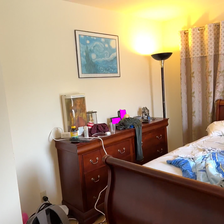

In [233]:
from PIL import Image

np_data = scene_state.sparse_ga.imgs[idx1]
Image.fromarray((np_data*255).astype(np.uint8))

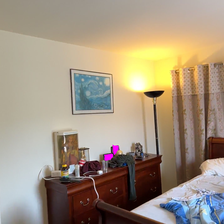

In [234]:
np_data = scene_state.sparse_ga.imgs[idx2]
Image.fromarray((np_data*255).astype(np.uint8))

In [235]:
H0, W0 = (224, 224)
H1, W1 = (224, 224)

corres_conf_fwd = f"corres_conf=desc_conf_subsample=8/{first_img_hash}-{second_img_hash}.pth"
score, (xy1, xy2, confs) = torch.load(f"/home/toskov/perspective-analysis-of-generated-images/feature_extraction/outputs/{corres_conf_fwd}")


valid_matches_im0 = (
    (xy1[:, 0] >= 3)
    & (xy1[:, 0] < int(W0) - 3)
    & (xy1[:, 1] >= 3)
    & (xy1[:, 1] < int(H0) - 3)
)

valid_matches_im1 = (
    (xy2[:, 0] >= 3)
    & (xy2[:, 0] < int(W1) - 3)
    & (xy2[:, 1] >= 3)
    & (xy2[:, 1] < int(H1) - 3)
)

valid_matches = valid_matches_im0 & valid_matches_im1
matches_im0, matches_im1 = xy1[valid_matches], xy2[valid_matches]

matches_im0 = matches_im0.cpu().numpy()
matches_im1 = matches_im1.cpu().numpy()

/tmp/ipykernel_9014/1091869598.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  score, (xy1, xy2, confs) = torch.load(f"/home/toskov/perspective-analysis-of-generated-ima

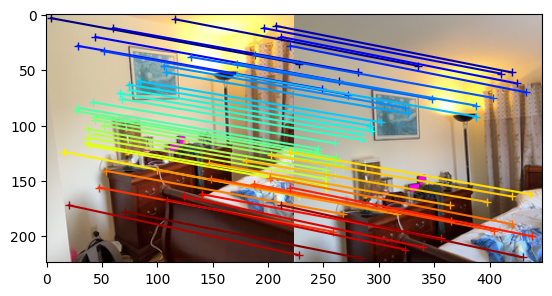

In [236]:
# visualize a few matches
import numpy as np
import torch
import torchvision.transforms.functional
from matplotlib import pyplot as pl

n_viz = 50
num_matches = matches_im0.shape[0]
match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
viz_matches_im0, viz_matches_im1 = (
    matches_im0[match_idx_to_viz],
    matches_im1[match_idx_to_viz],
)


viz_imgs = [scene_state.sparse_ga.imgs[idx1], scene_state.sparse_ga.imgs[idx2]]

H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
img0 = np.pad(
    viz_imgs[0],
    ((0, max(H1 - H0, 0)), (0, 0), (0, 0)),
    "constant",
    constant_values=0,
)
img1 = np.pad(
    viz_imgs[1],
    ((0, max(H0 - H1, 0)), (0, 0), (0, 0)),
    "constant",
    constant_values=0,
)
img = np.concatenate((img0, img1), axis=1)
pl.figure()
pl.imshow(img)
cmap = pl.get_cmap("jet")
for i in range(n_viz):
    (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
    pl.plot(
        [x0, x1 + W0],
        [y0, y1],
        "-+",
        color=cmap(i / (n_viz - 1)),
        scalex=False,
        scaley=False,
    )
pl.show()

In [237]:
pts_1 = scene_state.sparse_ga.get_sparse_pts3d()[idx1]
pts_2 = scene_state.sparse_ga.get_sparse_pts3d()[idx2]

print(pts_1.shape, xy1.shape)
print(pts_2.shape, xy2.shape)

torch.Size([25532, 3]) torch.Size([1984, 2])
torch.Size([22537, 3]) torch.Size([1984, 2])


In [238]:
print(scene_state.sparse_ga.get_dense_pts3d()[1][0].shape)
print(224 ** 2)

torch.Size([50176])
50176


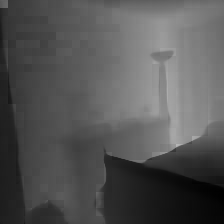

In [239]:
depth_1 = scene_state.sparse_ga.get_dense_pts3d()[1][idx1].reshape(224, 224)
Image.fromarray((((depth_1 - depth_1.min()) / depth_1.max()) * 255).cpu().numpy().astype(np.uint8))

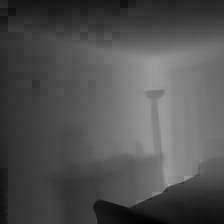

In [240]:
depth_2 = scene_state.sparse_ga.get_dense_pts3d()[1][idx2].reshape(224, 224)
Image.fromarray((((depth_2 - depth_2.min()) / depth_2.max()) * 255).cpu().numpy().astype(np.uint8))

In [241]:
im_1_points = scene_state.sparse_ga.get_dense_pts3d()[0][idx1].reshape(224, 224, 3)
im_2_points = scene_state.sparse_ga.get_dense_pts3d()[0][idx2].reshape(224, 224, 3)

# Using the keypoints, get the corresponding points in each image
# This seems to be the correct ordering (makes sense as matches will be row, col (y, x) and points will be (x,y)) 
im_1_keypoint_cloud = im_1_points[matches_im0[:,1],matches_im0[:,0]]
im_2_keypoint_cloud = im_2_points[matches_im1[:,1],matches_im1[:,0]]

In [242]:
print(im_1_keypoint_cloud)
print()
print(im_2_keypoint_cloud)

tensor([[ 4.9815, -2.9343, -3.1188],
        [ 4.9792, -2.9802, -3.1708],
        [ 4.6077, -2.4724, -2.4667],
        ...,
        [ 3.9113, -0.8001, -3.2605],
        [ 3.8302, -0.8083, -3.2924],
        [ 3.7479, -0.8213, -3.1549]], device='cuda:0')

tensor([[ 4.6746, -2.4475, -2.4569],
        [ 4.6746, -2.4475, -2.4569],
        [ 4.6105, -2.4912, -2.4886],
        ...,
        [ 3.9240, -0.7991, -3.3031],
        [ 3.8360, -0.8080, -3.3296],
        [ 3.7460, -0.8242, -3.2275]], device='cuda:0')


In [243]:
torch.nn.functional.mse_loss(im_1_keypoint_cloud, im_2_keypoint_cloud).item()

0.0018116889987140894

In [244]:
# What is the average distance between the two point clouds?
distances = torch.linalg.norm(im_1_keypoint_cloud - im_2_keypoint_cloud, dim=1, ord=2)
print(f"Mean: {distances.mean().item()}")
print(f"Std: {distances.std().item()}")
print(f"Max: {distances.max().item()}")
print(f"Min: {distances.min().item()}")

Mean: 0.038540810346603394
Std: 0.06286348402500153
Max: 1.0167570114135742
Min: 0.000826643721666187


In [245]:
# Show both point clouds

cloud_1 = trimesh.points.PointCloud(im_1_keypoint_cloud.cpu().numpy(), colors=np.repeat(np.array([[0, 0, 255]], dtype=np.uint8),im_1_keypoint_cloud.shape[0], axis=0))
cloud_2 = trimesh.points.PointCloud(im_2_keypoint_cloud.cpu().numpy(), colors=np.repeat(np.array([[255, 0, 0]], dtype=np.uint8),im_2_keypoint_cloud.shape[0], axis=0))


In [246]:
import open3d as o3d
import numpy as np

pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(cloud_1)
pcd1.paint_uniform_color([0, 0, 1])  # Blue

pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(cloud_2)
pcd2.paint_uniform_color([1, 0, 0])  # Red


# o3d.visualization.draw_geometries([pcd1, pcd2])

PointCloud with 1843 points.

In [247]:
np.array([[0, 255, 255]], dtype=np.uint8).shape

(1, 3)

In [248]:
im_1_keypoint_cloud.shape[0]

1843